In [3]:
import torch
import torch.nn.functional as F
from torch import nn
import torch.utils.data
from transformers import OFATokenizer, OFAConfig, OFAModel, LogitsProcessorList, AutoConfig, GPT2Tokenizer, BeamSearchScorer
from PIL import Image
from utils import proc_ques, top_filtering
from ofa_modeling import OFAForConditionalGeneration, OFAEncoder
from transformers import top_k_top_p_filtering
from PIL import Image
import numpy as np
import cv2, math
import matplotlib.pyplot as plt
from captum.attr import visualization
import json
from torchvision.transforms import GaussianBlur
import yaml
from tqdm import tqdm
import os

/home/pr03/anaconda3/envs/ofa/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# OFA-BASE_EA SOTA

In [ ]:
tokenizer = OFATokenizer.from_pretrained("OFA-base")  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = OFAConfig.from_pretrained("OFA_base_EA")
config.concentration_attn = False
config.concentration_hidden = False
ofa = OFAForConditionalGeneration.from_pretrained("OFA_base_EA",config=config, align_layer = None).to(device)
ofa.config.device= device

# OFA-BASE_AE SOTA

In [ ]:
tokenizer = OFATokenizer.from_pretrained("OFA-base")  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = OFAConfig.from_pretrained("OFA_base_AE")
config.concentration_attn = False
config.concentration_hidden = False
ofa = OFAForConditionalGeneration.from_pretrained("OFA_base_AE",config=config, align_layer = None).to(device)
ofa.config.device= device

# EXE_AE SOTA

In [ ]:
tokenizer = OFATokenizer.from_pretrained("OFA-base")  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = OFAConfig.from_pretrained("EXE_AE")
config.concentration_attn = True
config.concentration_hidden = False
ofa = OFAForConditionalGeneration.from_pretrained("EXE_AE",config=config, align_layer = None).to(device)
ofa.config.device= device

# EXE_EA SOTA

In [4]:
tokenizer = OFATokenizer.from_pretrained("OFA-base")  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = OFAConfig.from_pretrained("OFA_concalgn_attn_e5_EA_b32_s0")
config.alignment = True
config.concentration_attn = True
config.concentration_hidden = False
ofa = OFAForConditionalGeneration.from_pretrained("OFA_concalgn_attn_e5_EA_b32_s0",config=config, align_layer = None).to(device)
ofa.config.device= device

OFA-base
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


# Visualization

In [5]:
caption_save_path = '/media/storage/datasets/NLE_annotation/caption_data' 
annFileExp = '../self_training/cococaption/annotations/vqaX_test_annot_exp.json'
annFileFull = '../self_training/cococaption/annotations/vqaX_test_annot_full.json'
nle_data_test_path = '/media/storage/datasets/NLE_annotation/VQA-X/annotated/vqaX_test.json'
nle_data_val_path = '/media/storage/datasets/NLE_annotation/VQA-X/annotated/vqaX_val.json'
nle_data_train_path = '/media/storage/datasets/NLE_annotation/VQA-X/annotated/vqaX_train.json'

In [6]:
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    # Only take positive : Final attention map
    cam = cam.clamp(min=0).mean(dim=0)
    return cam
def handle_self_attention_image(encoder_blocks, R_i_i, one_hot):
    selfattn_map = []
    for blk in encoder_blocks:
        grad = torch.autograd.grad(one_hot, blk.self_attn.get_attn(), retain_graph=True)[0].detach()
        cam = blk.self_attn.get_attn().detach()
        cam = avg_heads(cam, grad)
        selfattn_map.append(torch.matmul(cam, R_i_i))
        R_i_i += torch.matmul(cam, R_i_i)
    return R_i_i, selfattn_map

def apply_self_attention_rules(R_ss, R_sq, cam_ss):
    R_sq_addition = torch.matmul(cam_ss, R_sq)
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition, R_sq_addition

def handle_co_attn_self_query(block, R_q_q, R_q_i, one_hot ):
    grad = torch.autograd.grad(one_hot, [block.self_attn.get_attn()], retain_graph=True)[0].detach()
    cam = block.self_attn.get_attn().detach()
    cam = avg_heads(cam, grad)
    R_q_q_add, R_q_i_add = apply_self_attention_rules(R_q_q, R_q_i, cam)
    R_q_q += R_q_q_add
    R_q_i += R_q_i_add
    return R_q_q, R_q_i

def handle_residual(orig_self_attention):
    self_attention = orig_self_attention.clone()
    diag_idx = range(self_attention.shape[-1])
    self_attention -= torch.eye(self_attention.shape[-1]).to(self_attention.device)
    assert self_attention[diag_idx, diag_idx].min() >= 0
    self_attention = self_attention / self_attention.sum(dim=-1, keepdim=True)
    self_attention += torch.eye(self_attention.shape[-1]).to(self_attention.device)
    return self_attention

def apply_mm_attention_rules(R_ss, R_qq, cam_sq, apply_normalization=True, apply_self_in_rule_10=True):
    R_ss_normalized = R_ss
    R_qq_normalized = R_qq
    if apply_normalization:
        R_ss_normalized = handle_residual(R_ss)
        R_qq_normalized = handle_residual(R_qq)
    R_sq_addition = torch.matmul(R_ss_normalized.t(), torch.matmul(cam_sq, R_qq_normalized))
    if not apply_self_in_rule_10:
        R_sq_addition = cam_sq
    R_sq_addition[torch.isnan(R_sq_addition)] = 0
    
    return R_sq_addition

def handle_co_attn_query(block, R_q_i, R_q_q, R_i_i, one_hot, apply_normalization):
    grad_q_i = torch.autograd.grad(one_hot, [block.cross_attn.get_attn()], retain_graph=True)[0].detach()
    cam_q_i = block.cross_attn.get_attn().detach()
    cam_q_i = avg_heads(cam_q_i, grad_q_i)
    R_q_i += apply_mm_attention_rules(R_q_q, R_i_i, cam_q_i, apply_normalization = apply_normalization, apply_self_in_rule_10=True)
    return R_q_i

def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam
    transform = GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2))
    # plt.axis('off')
    # f, axarr = plt.subplots(1,2)
    # axarr[0].imshow(orig_image)

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');
    
    feat_hw = int(math.sqrt(image_relevance.shape[-1]))
    image_relevance = image_relevance.reshape(1, 1, feat_hw, feat_hw)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = transform(image_relevance)
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    # axar[1].imshow(vis)
    axs[1].imshow(vis);
    axs[1].axis('off');
def show_heatmap_on_text(idx, text_encoding, R_text):
    text_scores = R_text / R_text.sum()
    text_scores = text_scores.flatten()
    text_tokens=text_encoding[idx]
    text_tokens_decoded=[tokenizer.decode([text_tokens])]
    vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
    visualization.visualize_text(vis_data_records)
    

def text_heatmap(text_tokens,text, R_text, top_k):
    if top_k is not None:
        v, idx  = torch.topk(R_text,top_k)
        sum = R_text.sum()
        # top-k scaler
        for index in idx:
            R_text[index.item()] += sum
    print(R_text)
    R_text /= R_text.sum()
    text_scores = R_text.flatten()
    print(text_scores)
    dec_tokens = [tokenizer.decode([a]) for a in text_tokens]
    vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,text,0,dec_tokens,1)]
    visualization.visualize_text(vis_data_records)

In [7]:
cached_features_file = "/media/storage/checkpoints/OFA/base/cached/cached_vqax_total_test_modeEA.pt"
features_and_dataset = torch.load(cached_features_file)
data = features_and_dataset["datasets"]

In [49]:
img_size = 224
do_sample = False
top_k =  0
top_p =  0.9
temperature = 1
start_layer = 11
load_from_epoch = 11
max_seq_len = 25
i = 713
# i =1634

so_token = tokenizer.convert_tokens_to_ids("Ġso")
image_path, input_ids, labels, img, patch_mask, image_id, decoder_input_ids, qid = data[i].values()
input_ids = input_ids.unsqueeze(0).to(device)
# input_attn_mask = _prepare_attention_mask_for_generation(input_ids,tokenizer)
img = img.to(device)
# decoder_input_ids = torch.tensor([tokenizer.convert_tokens_to_ids("because")], dtype=torch.long).unsqueeze(0).to(device)
img = img.unsqueeze(0)
patch_mask = patch_mask.to(device)
decoder_input_ids = torch.tensor(tokenizer.bos_token_id, dtype = torch.long).unsqueeze(0).unsqueeze(0).to(device)

In [50]:
logits_processor = ofa._get_logits_processor(
    repetition_penalty=None,
    no_repeat_ngram_size=None,
    encoder_no_repeat_ngram_size=None,
    input_ids_seq_length=decoder_input_ids.shape[-1],
    encoder_input_ids=input_ids,
    bad_words_ids=None,
    min_length=None,
    max_length=max_seq_len,
    eos_token_id=tokenizer.eos_token_id,
    forced_bos_token_id=tokenizer.bos_token_id,
    forced_eos_token_id=tokenizer.eos_token_id,
    prefix_allowed_tokens_fn=None,
    num_beams=None,
    num_beam_groups=None,
    diversity_penalty=None,
    remove_invalid_values=None,
    exponential_decay_length_penalty=None,
    logits_processor=LogitsProcessorList(),
)

In [51]:
# Beam Search
tokenizer.decode(ofa.generate(input_ids, patch_images = img, max_length = 30, num_beams=4)[0])

/home/pr03/anaconda3/envs/ofa/lib/python3.7/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


'<s><s> there is graffiti on the side of the bus so the answer is yes</s>'

In [52]:
# Greed Search
tokenizer.decode(ofa.generate(input_ids, patch_images = img, max_length = 30)[0])

'<s><s> it is a large bus with many windows so the answer is yes</s>'

In [53]:
torch.manual_seed(42)
concentration = False
current_output = []
num_beams =None
batch_size = 1
# num_beams = 4
answer_start = False
answer_txt = []
explanation_txt = []
answer_relevance_maps = []
explanation_relevance_maps = []
image_relevance = []
self_attn_relevancemap = []
EA_self_attn_relev = []
normalization = True
pil_image = Image.open(image_path)

SPECIAL_TOKENS = ['<|endoftext|>', '<pad>', '<question>', '<answer>', '<explanation>']
special_tokens_ids = tokenizer.convert_tokens_to_ids(SPECIAL_TOKENS)

model_kargs = {"patch_images" : img, 'output_attentions': False, 'output_hidden_states': False}
model_kargs = ofa._prepare_encoder_decoder_kwargs_for_generation(
        inputs_tensor=input_ids,
        model_kwargs = model_kargs,
        model_input_name = "input_ids"
)

max_seq_len=30

for step in tqdm(range(max_seq_len+1), ): 
        encoder_blocks = list(dict(ofa.encoder.layers.named_children()).values())
        decoder_blocks = list(dict(ofa.decoder.layers.named_children()).values())
        model_kwargs = ofa.prepare_inputs_for_generation(
                decoder_input_ids=decoder_input_ids,
                **model_kargs,
                )        
        outputs = ofa(return_dict=True,**model_kwargs)

        unfinished_sequences = decoder_input_ids.new(decoder_input_ids.shape[0]).fill_(1)
        cur_len = decoder_input_ids.shape[-1]
        logits = outputs.logits
        next_token_logits = logits[:, -1, :]
        next_tokens_scores = logits_processor(decoder_input_ids, next_token_logits)
        next_tokens = torch.argmax(next_tokens_scores, dim=-1)
        next_tokens = next_tokens * unfinished_sequences + tokenizer.pad_token_id * (1 - unfinished_sequences)
        if num_beams is not None:
                next_tokens = torch.tensor([next_tokens[0].item()]).to(device)
                next_token_logits = next_token_logits[0]
                decoder_input_ids = decoder_input_ids[0].unsqueeze(0)
        
        one_hot = F.one_hot(next_tokens, num_classes = next_token_logits.shape[-1]).type(torch.float32)
        one_hot = torch.sum(one_hot.cuda()*next_token_logits, dim=-1)
        one_hot = one_hot.requires_grad_(True).cuda()
        image_bboxes = encoder_blocks[0].self_attn.get_attn().shape[-1]
        self_queries_num =  decoder_blocks[0].self_attn.get_attn().shape[-1]

        queries_num = decoder_blocks[0].cross_attn.get_attn().shape[-1]
        # image self attention matrix
        R_i_i = torch.eye(image_bboxes, image_bboxes).to(encoder_blocks[0].self_attn.get_attn().device)
        # queries self attention matrix
        R_q_q = torch.eye(self_queries_num, self_queries_num).to(encoder_blocks[0].self_attn.get_attn().device)
        # impact of image boxes on queries
        # R_q_i = torch.zeros(self_queries_num, image_bboxes).to(encoder_blocks[0].self_attn.attn.device)
        R_q_i = torch.zeros(self_queries_num, image_bboxes ).to(encoder_blocks[0].self_attn.attn.device)

        R_i_i, slfattn_map = handle_self_attention_image(encoder_blocks, R_i_i, one_hot )
        
        for blk in decoder_blocks:
                # decoder self attention
                R_q_q, R_q_i = handle_co_attn_self_query(blk, R_q_q, R_q_i, one_hot)

                # encoder decoder attention
                R_q_i = handle_co_attn_query(blk, R_q_i, R_q_q, R_i_i, one_hot, apply_normalization = normalization)

        EA_self_attn_relev.append(R_q_q)
        aggregated = R_q_i.unsqueeze_(0)
        image_rel = R_i_i.unsqueeze_(0)
        self_attn_relevancemap.append(image_rel)
        # take last word+
        multimodal_relevance = aggregated[:,-1,:].unsqueeze_(0)
        
        # For image relevance map
        
        image_rel = torch.sum(image_rel, axis = 1).unsqueeze_(0)
        
        if next_tokens.item() in special_tokens_ids:
                break
        
        # answer start
        if next_tokens.item() == so_token:
                answer_start = True  
        # answer generation
        if answer_start:
                answer_txt.append(next_tokens.item())
                answer_relevance_maps.append(multimodal_relevance)
                
        # explanation generation
        else:
                explanation_txt.append(next_tokens.item())
                explanation_relevance_maps.append(multimodal_relevance)

        current_output.append(next_tokens.item())
        image_relevance.append(image_rel)
        decoder_input_ids = torch.cat([decoder_input_ids, next_tokens[:, None]], dim=-1)
        model_kwargs = ofa._update_model_kwargs_for_generation(outputs, model_kwargs, is_encoder_decoder=True)
        unfinished_sequences = unfinished_sequences.mul((next_tokens != tokenizer.eos_token_id).long())

 48%|████▊     | 15/31 [00:06<00:06,  2.34it/s]


In [11]:
tokenizer.decode(decoder_input_ids[0])

'<s><s> it is a large bus with many windows so the answer is yes</s>'

In [54]:
# Normalization
for exp in explanation_relevance_maps:
    exp[0][0][:14] =0.0
    for num in range(0,196,14):
        exp[0][0][num] = 0.0

for ans in answer_relevance_maps:
    ans[0][0][:14] =0.0
    for num in range(0,196,14):
        ans[0][0][num] = 0.0
        
for imgg in image_relevance:
    imgg[0][0][:14] =1.0
    for num in range(0,196,14):
        imgg[0][0][num] = 1.0

In [55]:
image_relevance[-1]

tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0020,
          1.0048, 1.0036, 1.0045, 1.0048, 1.0050, 1.0044, 1.0028, 1.0026,
          1.0052, 1.0041, 1.0032, 1.0058, 1.0000, 1.0020, 1.0023, 1.0023,
          1.0025, 1.0023, 1.0025, 1.0032, 1.0039, 1.0043, 1.0025, 1.0045,
          1.0049, 1.0044, 1.0000, 1.0020, 1.0030, 1.0035, 1.0039, 1.0041,
          1.0062, 1.0036, 1.0059, 1.0060, 1.0074, 1.0062, 1.0050, 1.0035,
          1.0000, 1.0023, 1.0039, 1.0042, 1.0038, 1.0058, 1.0054, 1.0050,
          1.0068, 1.0104, 1.0058, 1.0086, 1.0047, 1.0037, 1.0000, 1.0031,
          1.0042, 1.0055, 1.0103, 1.0140, 1.0077, 1.0068, 1.0081, 1.0194,
          1.0070, 1.0104, 1.0046, 1.0048, 1.0000, 1.0032, 1.0052, 1.0103,
          1.0152, 1.0135, 1.0159, 1.0070, 1.0110, 1.0096, 1.0092, 1.0119,
          1.0059, 1.0048, 1.0000, 1.0041, 1.0056, 1.0093, 1.0138, 1.0154,
          1.0168, 1.0100, 1.0093, 1.01

In [59]:
image_relevance[-1][:,:,14:196]
img_prac = image_relevance[-1][:,:,:196].clone().detach()

In [ ]:
img_prac -= torch.mean(img_prac)
print(img_prac)
img_prac += torch.abs(img_prac)
# image_relevance[-1] += img_prac

In [61]:
image_relevance[-1][:,:,:196] += img_prac
image_relevance[-1]

tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0020,
          1.0048, 1.0036, 1.0045, 1.0048, 1.0050, 1.0044, 1.0028, 1.0026,
          1.0052, 1.0041, 1.0032, 1.0058, 1.0000, 1.0020, 1.0023, 1.0023,
          1.0025, 1.0023, 1.0025, 1.0032, 1.0039, 1.0043, 1.0025, 1.0045,
          1.0049, 1.0044, 1.0000, 1.0020, 1.0030, 1.0035, 1.0039, 1.0041,
          1.0062, 1.0036, 1.0059, 1.0060, 1.0091, 1.0062, 1.0050, 1.0035,
          1.0000, 1.0023, 1.0039, 1.0042, 1.0038, 1.0058, 1.0054, 1.0050,
          1.0074, 1.0183, 1.0058, 1.0127, 1.0047, 1.0037, 1.0000, 1.0031,
          1.0042, 1.0055, 1.0180, 1.0291, 1.0102, 1.0075, 1.0114, 1.0451,
          1.0080, 1.0183, 1.0046, 1.0048, 1.0000, 1.0032, 1.0052, 1.0178,
          1.0326, 1.0275, 1.0347, 1.0080, 1.0200, 1.0158, 1.0146, 1.0228,
          1.0059, 1.0048, 1.0000, 1.0041, 1.0056, 1.0148, 1.0283, 1.0333,
          1.0375, 1.0171, 1.0149, 1.02

: 

In [38]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()

In [46]:
image_relevance[-1][:,:,14:196]
img_prac2 = image_relevance[-1][:,:,:196].clone().detach().cpu()
print(img_prac2)
img_prac2 = minmax_scaler.fit_transform(img_prac2[0])
img_prac2

tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0020,
          1.0048, 1.0036, 1.0045, 1.0048, 1.0050, 1.0044, 1.0028, 1.0026,
          1.0052, 1.0041, 1.0032, 1.0058, 1.0000, 1.0020, 1.0023, 1.0023,
          1.0025, 1.0023, 1.0025, 1.0032, 1.0039, 1.0043, 1.0025, 1.0045,
          1.0049, 1.0044, 1.0000, 1.0020, 1.0030, 1.0035, 1.0039, 1.0041,
          1.0062, 1.0036, 1.0059, 1.0060, 1.0074, 1.0062, 1.0050, 1.0035,
          1.0000, 1.0023, 1.0039, 1.0042, 1.0038, 1.0058, 1.0054, 1.0050,
          1.0068, 1.0104, 1.0058, 1.0086, 1.0047, 1.0037, 1.0000, 1.0031,
          1.0042, 1.0055, 1.0103, 1.0140, 1.0077, 1.0068, 1.0081, 1.0194,
          1.0070, 1.0104, 1.0046, 1.0048, 1.0000, 1.0032, 1.0052, 1.0103,
          1.0152, 1.0135, 1.0159, 1.0070, 1.0110, 1.0096, 1.0092, 1.0119,
          1.0059, 1.0048, 1.0000, 1.0041, 1.0056, 1.0093, 1.0138, 1.0154,
          1.0168, 1.0100, 1.0093, 1.01

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [42]:
img_prac2[0]

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0020, 1.0048, 1.0036,
         1.0045, 1.0048, 1.0050, 1.0044, 1.0028, 1.0026, 1.0052, 1.0041, 1.0032,
         1.0058, 1.0000, 1.0020, 1.0023, 1.0023, 1.0025, 1.0023, 1.0025, 1.0032,
         1.0039, 1.0043, 1.0025, 1.0045, 1.0049, 1.0044, 1.0000, 1.0020, 1.0030,
         1.0035, 1.0039, 1.0041, 1.0062, 1.0036, 1.0059, 1.0060, 1.0074, 1.0062,
         1.0050, 1.0035, 1.0000, 1.0023, 1.0039, 1.0042, 1.0038, 1.0058, 1.0054,
         1.0050, 1.0068, 1.0104, 1.0058, 1.0086, 1.0047, 1.0037, 1.0000, 1.0031,
         1.0042, 1.0055, 1.0103, 1.0140, 1.0077, 1.0068, 1.0081, 1.0194, 1.0070,
         1.0104, 1.0046, 1.0048, 1.0000, 1.0032, 1.0052, 1.0103, 1.0152, 1.0135,
         1.0159, 1.0070, 1.0110, 1.0096, 1.0092, 1.0119, 1.0059, 1.0048, 1.0000,
         1.0041, 1.0056, 1.0093, 1.0138, 1.0154, 1.0168, 1.0100, 1.0093, 1.0136,
         1.0093, 1.0119, 1.0

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7655e-03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2084e-04, 7.8504e-03,
        0.0000e+00, 4.1156e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 7.6962e-

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),is that a commercial bus?,0.00,#s is that a commercial bus ? #/s


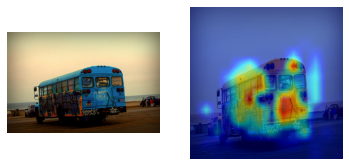

In [36]:
img_map = img_prac.clone().detach()
text_score = img_prac[0][0].clone().detach()
text_heatmap(input_ids[0], tokenizer.decode(input_ids[0]),text_score, 3)
show_image_relevance(img_map, img, pil_image)
plt.show()

tensor([1.1076, 1.0666, 9.9524, 1.0527, 9.9351, 9.9788, 1.0813, 1.0845],
       device='cuda:0')
tensor([0.0314, 0.0303, 0.2823, 0.0299, 0.2818, 0.2830, 0.0307, 0.0308],
       device='cuda:0')


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),is that a commercial bus?,0.00,#s is that a commercial bus ? #/s


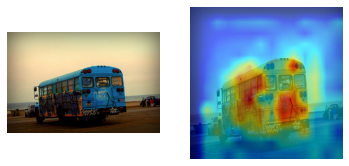

In [35]:
img_map = image_relevance[-1][:,:,:196].clone().detach()
text_score = image_relevance[-1][:,:,196:][0][0].clone().detach()
text_heatmap(input_ids[0], tokenizer.decode(input_ids[0]),text_score, 3)
show_image_relevance(img_map, img, pil_image)
plt.show()

Question>>>>  is that a commercial bus?
Answer>>>>  it is a large bus with many windows so the answer is yes


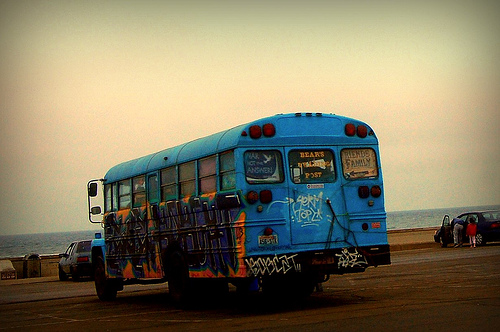

In [37]:
output_txt = tokenizer.decode(current_output)
pil_image = Image.open(image_path)
print("Question>>>>",tokenizer.decode(input_ids[0],  skip_special_tokens=True))
print("Answer>>>>",tokenizer.decode(current_output,  skip_special_tokens=True))
pil_image

In [ ]:
image_relevance[0].shape

In [ ]:
# Encoder relevance map
for idx, txt_map in enumerate(image_relevance):
    output_txt = tokenizer.decode(current_output[idx])
    print(f"******{output_txt}*********")
    img_map = txt_map[:,:,:196].clone().detach()
    text_score = txt_map[:,:,196:][0][0].clone().detach()
    text_heatmap(input_ids[0], tokenizer.decode(input_ids[0]),text_score, 3)
    show_image_relevance(img_map, img, pil_image)
    plt.show()

In [ ]:
for idx, txt_map in enumerate(explanation_relevance_maps +answer_relevance_maps):
    txt_map = txt_map[:,:,:196](텔레비전·라디오의) 광고 (방송)

    show_heatmap_on_text(idx,current_output, txt_map)
    show_image_relevance(txt_map, img, pil_image)
    plt.show()

# Beam Search

In [ ]:
# Beam Search

torch.manual_seed(32)
concentration = False
current_output = []
num_beams =4
batch_size = 1
answer_start = False
answer_txt = []
explanation_txt = []
answer_relevance_maps = []
explanation_relevance_maps = []
image_relevance = []
self_attn_relevancemap = []
EA_self_attn_relev = []
normalization = True
pil_image = Image.open(image_path)

SPECIAL_TOKENS = ['<|endoftext|>', '<pad>', '<question>', '<answer>', '<explanation>']
special_tokens_ids = tokenizer.convert_tokens_to_ids(SPECIAL_TOKENS)

model_kargs = {"patch_images" : img, 'output_attentions': False, 'output_hidden_states': False}
model_kargs = ofa._prepare_encoder_decoder_kwargs_for_generation(
        inputs_tensor=input_ids,
        model_kwargs = model_kargs,
        model_input_name = "input_ids"
)
# Beam search
beam_scorer = BeamSearchScorer(
        batch_size=batch_size,
        num_beams=num_beams,
        device=device,
        length_penalty=1.0,
        do_early_stopping=False,
        num_beam_hyps_to_keep=1,
        )
decoder_input_ids, model_kwargs = ofa._expand_inputs_for_generation(
                decoder_input_ids, expand_size=num_beams, is_encoder_decoder=config.is_encoder_decoder, **model_kargs)
beam_scores = torch.zeros((batch_size, num_beams), dtype=torch.float, device=device)
beam_scores[:, 1:] = -1e9
beam_scores = beam_scores.view((batch_size * num_beams,))
this_peer_finished = False  # used by synced_gpus only
beam_answer_relevance = [[] for n in range(num_beams)]
beam_explanation_relevance = [[] for n in range(num_beams)]
for step in tqdm(range(max_seq_len+1), ): 
        encoder_blocks = list(dict(ofa.encoder.layers.named_children()).values())
        decoder_blocks = list(dict(ofa.decoder.layers.named_children()).values())
        model_kwargs = ofa.prepare_inputs_for_generation(
                decoder_input_ids=decoder_input_ids,
                **model_kargs,
                )        
        outputs = ofa(return_dict=True,**model_kwargs)

        unfinished_sequences = decoder_input_ids.new(decoder_input_ids.shape[0]).fill_(1)
        batch_beam_size, cur_len = decoder_input_ids.shape
        logits = outputs.logits
        next_token_logits = logits[:, -1, :]
        next_token_logits = ofa.adjust_logits_during_generation(next_token_logits, cur_len=cur_len)
        next_token_scores = nn.functional.log_softmax(
        next_token_logits, dim=-1
        )  # (batch_size * num_beams, vocab_size)

        next_token_scores_processed = logits_processor(decoder_input_ids, next_token_scores)
        next_token_scores = next_token_scores_processed + beam_scores[:, None].expand_as(next_token_scores)
        vocab_size = next_token_scores.shape[-1]
        next_token_scores = next_token_scores.view(batch_size, num_beams * vocab_size)

        next_token_scores, next_tokens = torch.topk(
        next_token_scores, 2 * num_beams, dim=1, largest=True, sorted=True
        )

        next_indices = torch.div(next_tokens, vocab_size, rounding_mode="floor")
        next_tokens = next_tokens % vocab_size

        # stateless
        beam_outputs = beam_scorer.process(
        decoder_input_ids,
        next_token_scores,
        next_tokens,
        next_indices,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        )

        beam_scores = beam_outputs["next_beam_scores"]
        beam_next_tokens = beam_outputs["next_beam_tokens"]
        beam_idx = beam_outputs["next_beam_indices"]
        
        for num, next_token in enumerate(beam_next_tokens):
                next_token = torch.tensor([next_token.item()]).to(device)
                token_logit = next_token_logits[num].unsqueeze(0)
                one_hot = F.one_hot(next_token, num_classes = token_logit.shape[-1]).type(torch.float32)
                one_hot = torch.sum(one_hot.cuda()*token_logit, dim=-1)
                one_hot = one_hot.requires_grad_(True).cuda()
                image_bboxes = encoder_blocks[0].self_attn.get_attn().shape[-1]
                self_queries_num =  decoder_blocks[0].self_attn.get_attn().shape[-1]

                queries_num = decoder_blocks[0].cross_attn.get_attn().shape[-1]
                # image self attention matrix
                R_i_i = torch.eye(image_bboxes, image_bboxes).to(encoder_blocks[0].self_attn.get_attn().device)
                # queries self attention matrix
                R_q_q = torch.eye(self_queries_num, self_queries_num).to(encoder_blocks[0].self_attn.get_attn().device)
                # impact of image boxes on queries
                # R_q_i = torch.zeros(self_queries_num, image_bboxes).to(encoder_blocks[0].self_attn.attn.device)
                R_q_i = torch.zeros(self_queries_num, image_bboxes ).to(encoder_blocks[0].self_attn.attn.device)

                R_i_i, slfattn_map = handle_self_attention_image(encoder_blocks, R_i_i, one_hot )
                
                for blk in decoder_blocks:
                        # decoder self attention
                        R_q_q, R_q_i = handle_co_attn_self_query(blk, R_q_q, R_q_i, one_hot)

                        # encoder decoder attention
                        R_q_i = handle_co_attn_query(blk, R_q_i, R_q_q, R_i_i, one_hot, apply_normalization = normalization)

                EA_self_attn_relev.append(R_q_q)
                aggregated = R_q_i.unsqueeze_(0)
                image_rel = R_i_i.unsqueeze_(0)
                self_attn_relevancemap.append(image_rel)
                # take last word+
                multimodal_relevance = aggregated[:,-1,:].unsqueeze_(0)
                
                # For image relevance map
                
                image_rel = torch.sum(image_rel, axis = 1).unsqueeze_(0)
                
                if next_token in special_tokens_ids:
                        break
                
                # answer start
                if next_token == so_token:
                        answer_start = True  
                # answer generation
                if answer_start:
                        answer_txt.append(next_token)
                        beam_answer_relevance[num].append(multimodal_relevance)
                        
                # explanation generation
                else:
                        explanation_txt.append(next_token)
                        beam_explanation_relevance[num].append(multimodal_relevance)



        model_kwargs = ofa._update_model_kwargs_for_generation(
                outputs, model_kwargs, is_encoder_decoder=ofa.config.is_encoder_decoder
            )
        if model_kwargs["past"] is not None:
                model_kwargs["past"] = ofa._reorder_cache(model_kwargs["past"], beam_idx)

        # increase cur_len
        cur_len = cur_len + 1

        # current_output.append(next_tokens.item())
        # image_relevance.append(image_rel)
        decoder_input_ids = torch.cat([decoder_input_ids[beam_idx, :], beam_next_tokens.unsqueeze(-1)], dim=-1)
        if beam_scorer.is_done:
                    break
sequence_outputs = beam_scorer.finalize(
        decoder_input_ids,
        beam_scores,
        next_tokens,
        next_indices,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        max_length=max_seq_len,
)

In [ ]:
# Normalization
for exp in beam_explanation_relevance[0]:
    exp[0][0][:14] =0.0
    for num in range(0,196,14):
        exp[0][0][num] = 0.0

for ans in beam_answer_relevance[0]:
    ans[0][0][:14] =0.0
    for num in range(0,196,14):
        ans[0][0][num] = 0.0
        
for imgg in image_relevance:
    imgg[0][0][:14] =1.0
    for num in range(0,196,14):
        imgg[0][0][num] = 1.0

In [ ]:
for idx, txt_map in enumerate(explanation_relevance_maps +answer_relevance_maps):
    txt_map = txt_map[:,:,:196]
    show_heatmap_on_text(idx,current_output, txt_map)
    show_image_relevance(txt_map, img, pil_image)
    plt.show()

# Cross in the self attention relevance map

In [ ]:
cross_in_self = self_attn_relevancemap[3][:,196:,:196].cpu().detach()
for idx, txt_map in enumerate(cross_in_self[0]):
    txt_map[:14] =0.0
    for num in range(0,196,14):
        txt_map[num] = 0.0
    txt_map = txt_map.unsqueeze(0)
    show_heatmap_on_text(idx,input_ids[0], txt_map)
    show_image_relevance(txt_map, img, pil_image)
    plt.show()

# Self attention answer and explanation

In [ ]:
EA_self_attn_relev[-1].unsqueeze(0)

In [ ]:
ex = EA_self_attn_relev[-1].cpu().detach()
torch.sum(ex, axis =0 )

In [ ]:
ex2 = EA_self_attn_relev[-1].cpu().detach()
torch.sum(ex2, axis =1 )

In [ ]:
tokenizer.decode(current_output)

In [ ]:
def text_heatmap(text_tokens,text, R_text, top_k):
    if top_k is not None:
        v, idx  = torch.topk(R_text,top_k)
        sum = R_text.sum()
        # top-k scaler
        for index in idx:
            R_text[index.item()] += sum
    print(R_text)
    R_text /= R_text.sum()
    text_scores = R_text.flatten()
    print(text_scores)
    dec_tokens = [tokenizer.decode([a]) for a in text_tokens]
    vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,text,0,dec_tokens,1)]
    visualization.visualize_text(vis_data_records)

In [ ]:
# Encoder relevance map
for idx, self_txt_map in enumerate(EA_self_attn_relev):
    if idx < 3:
        k = None
    else:
        k = 3
    output_txt = tokenizer.decode(current_output[idx])
    print(f"******{output_txt}*********")
    text_score = self_txt_map.clone().detach()
    text_score = torch.sum(text_score, axis = 0)
    text_heatmap(current_output[:idx], tokenizer.decode(current_output[0]), text_score, top_k = k)
    # show_image_relevance(img_map, img, pil_image)
    plt.show()

In [ ]:
explanation_relevance_maps[1].shape

In [ ]:
explanation_relevance_maps[1][:196]

In [ ]:
explanation_relevance_maps[1][:,:,196:]

In [ ]:
image_relevance[1][:,:,:196]

In [ ]:
image_relevance[1][:,:,196:]